# Independent Component Analysis of Energy Futures

This notebook applies Independent Component Analysis (ICA) to multivariate
energy futures returns in order to identify latent market factors.

The analysis focuses on power, natural gas, coal, and oil-related futures.
All series have been preprocessed and standardized to ensure cross-market
comparability.


In [2]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.decomposition import PCA,FastICA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

The input data consist of daily log returns of energy futures prices.
Prior preprocessing steps include:

- Currency standardization to USD
- Unit harmonization within the same energy type
- Categorization of petroleum products into crude oil and refined oil
- Log-return transformation to remove scale effects

These steps ensure that ICA extracts latent dependence structures rather
than artifacts driven by heterogeneous price units or magnitudes.


In [3]:
files = glob.glob(os.path.join("./data/merchandise/*.csv"))

mer ={}

for i in files:
    name =os.path.splitext(os.path.basename(i))[0]
    df = pd.read_csv(i, index_col=0, parse_dates=True)
    mer[name] = df
    print(f"{name} \n {mer[name]} \n")



coal 
                  LQX       LUX       LVX
Time                                    
2022-06-07 -0.028535 -0.000560 -0.004833
2022-06-08 -0.008305 -0.000280 -0.027175
2022-06-09  0.009223  0.019709  0.045735
2022-06-10 -0.051571 -0.006619  0.050992
2022-06-13  0.035841 -0.001107  0.010788
...              ...       ...       ...
2025-10-30 -0.009141  0.004547 -0.006238
2025-10-31  0.003209 -0.025525 -0.021853
2025-11-03  0.003199 -0.004664 -0.003494
2025-11-04  0.011341  0.015464  0.012754
2025-11-05 -0.008152 -0.005642  0.004024

[883 rows x 3 columns] 

crude_oil 
                  CBF       WIZ
Time                          
2022-06-07  0.018885  0.022927
2022-06-08  0.008434  0.008464
2022-06-09  0.006621  0.011572
2022-06-10 -0.006997 -0.005969
2022-06-13  0.009609  0.009269
...              ...       ...
2025-10-30  0.000777  0.001487
2025-10-31  0.006195  0.006746
2025-11-03  0.001851  0.001147
2025-11-04 -0.006959 -0.008059
2025-11-05 -0.014380 -0.015979

[883 rows x 2 colu

In [4]:
os.makedirs("./data/plot/PCA", exist_ok=True)

for name, df in mer.items():
    x = mer[name]
    x_std = StandardScaler().fit_transform(x)

    pca = PCA().fit(x_std)

    explained = pca.explained_variance_ratio_
    cum_explained = explained.cumsum()

    k = np.arange(1, len(cum_explained) + 1)

    plt.figure()
    plt.plot(k,cum_explained, marker="o")
    plt.axhline(0.8, color="red", linestyle="--")
    plt.axhline(0.9, color="blue", linestyle="--")
    plt.title(f"{name} PCA cumulative explained variance")
    plt.xlabel("Number of components")
    plt.ylabel("Cumulative explained variance")
    plt.tight_layout()
    plt.savefig(f"./data/plot/PCA/{name}.png", dpi=300)
    plt.close()

## Motivation for Independent Component Analysis

Energy markets are influenced by multiple latent forces such as fuel
substitution, demand shocks, and policy-related effects.
These forces are not directly observable and may affect multiple markets
simultaneously.

Independent Component Analysis (ICA) is employed to decompose observed
multivariate returns into statistically independent components, each of
which may be interpreted as an underlying market factor.

Unlike PCA, which maximizes variance, ICA focuses on higher-order
statistics and non-Gaussianity, making it more suitable for uncovering
structural drivers in financial time series.


In [5]:
df = pd.read_csv('./data/log_return.csv')

df["Time"] = pd.to_datetime(df["Time"])
df = df.set_index("Time")   # set as index

x = df   # Time only use to be index, no need to be input
x_std = StandardScaler().fit_transform(x.values)

pca = PCA().fit(x_std)

explained = pca.explained_variance_ratio_
cum_explained = explained.cumsum()

k = np.arange(1, len(cum_explained) + 1)

plt.figure()
plt.plot(k,cum_explained, marker="o")
plt.axhline(0.8, color="red", linestyle="--")
plt.axhline(0.9, color="blue", linestyle="--")
plt.title(f"All mechandise PCA cumulative explained variance")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.tight_layout()
plt.savefig(f"./data/plot/PCA/All.png", dpi=300)
plt.close()

## Determination of the Number of Independent Components

Selecting an appropriate number of independent components (k) is a
non-trivial problem in ICA, as the method does not provide an intrinsic
criterion for model order selection.

In this study, the choice of k is guided by a combination of statistical
and interpretability considerations rather than a single optimality
criterion.

Specifically, we consider the following principles:

- **Stability of extracted components**:  
  The number of components should be sufficient to capture stable and
  reproducible structures across different ICA variants.

- **Structural interpretability**:  
  Increasing k may lead to components that are dominated by noise or
  become difficult to interpret economically.

- **Dimensional consistency**:  
  The selected k should remain well below the number of observed
  variables to avoid over-fragmentation of latent factors.

Rather than treating k as a strictly optimal parameter, we interpret it
as a modeling choice that balances explanatory richness and robustness.
Subsequent analyses focus on whether the extracted components exhibit
consistent temporal and structural patterns.


In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from scipy.optimize import linear_sum_assignment

# -----------------------------
# similarity function (use A)
# -----------------------------
def ica_similarity(A1, A2):
    """
    A1, A2: (p, k) mixing matrices
    return: mean abs correlation after optimal matching
    """
    k = A1.shape[1]
    C = np.corrcoef(A1.T, A2.T)[:k, k:]   # (k, k)
    C = np.abs(C)                         # sign ambiguity
    r, c = linear_sum_assignment(-C)      # maximize correlation
    return C[r, c].mean()

def stability_of_A_list(A_list):
    """mean similarity across all pairs in A_list"""
    sims = []
    for i in range(len(A_list)):
        for j in range(i + 1, len(A_list)):
            sims.append(ica_similarity(A_list[i], A_list[j]))
    return float(np.mean(sims)), float(np.std(sims))

# -----------------------------
# assume you already have x_std
# x_std: (T, p) numeric matrix
# -----------------------------

results = []

for k in range(5,13):
    # 1) PCA to k dims (optional but common before ICA)
    x_pca = PCA(n_components=k, random_state=0).fit_transform(x_std)

    # 2) run ICA multiple seeds, store A
    A_list = []
    for seed in range(10):
        ica = FastICA(
            n_components=k,
            random_state=seed,
            whiten="unit-variance",
            max_iter=2000,
            tol=1e-4
        )
        S = ica.fit_transform(x_pca)  # (T, k)
        A = ica.mixing_               # (k, k) because input is k-dim after PCA
        A_list.append(A)

    # 3) stability score for this k
    mean_sim, std_sim = stability_of_A_list(A_list)
    results.append((k, mean_sim, std_sim))

res_df = pd.DataFrame(results, columns=["k", "mean_similarity", "std_similarity"])
print(res_df.sort_values("mean_similarity", ascending=False))


    k  mean_similarity  std_similarity
0   5         0.997367        0.003214
3   8         0.986449        0.009910
1   6         0.983312        0.033147
4   9         0.982468        0.021354
7  12         0.979799        0.023578
2   7         0.959829        0.042651
6  11         0.958531        0.031352
5  10         0.953607        0.037834


## ICA Variants Considered

Two ICA variants are considered in this analysis:

- **FastICA**, which estimates components by maximizing non-Gaussianity
  using a fixed-point iteration scheme.
- **Sparse ICA**, which introduces sparsity constraints to encourage
  more interpretable and localized component structures.

Both methods are applied to the same standardized dataset to allow
a direct comparison of extracted components.


In [7]:
pca = PCA(n_components=8, random_state=0)
x_pca = pca.fit_transform(x_std)                 # (T, k)

ica = FastICA(
    n_components=8,
    random_state=0,
    whiten="unit-variance", # whiten
    max_iter=2000,
    tol=1e-4
)
S = ica.fit_transform(x_pca)                     # (T, k)
A = ica.mixing_                                  # (k, k)

# Correct back-projection to the original 17-dimensional space:
# (k, k) @ (k, 17) -> (k, 17)
A_orig_T = A @ pca.components_                   # (k, 17)
A_orig = A_orig_T.T                              # (17, k)

S_df = pd.DataFrame(S, index=df.index, columns=[f"IC{i+1}" for i in range(8)])
A_df = pd.DataFrame(A_orig, index=df.columns, columns=[f"IC{i+1}" for i in range(8)])

In [8]:
signs = []
for col in A_df.columns:
    # Identify the source with the largest absolute loading for this IC
    top_src = A_df[col].abs().idxmax()

    # Use the sign of the dominant loading to enforce a positive orientation
    val = A_df.loc[top_src, col]
    signs.append(np.sign(val) if val != 0 else 1.0)

signs = np.array(signs)

# Flip signs consistently for both loadings and time series
A_df = A_df * signs
S_df = S_df * signs

print(A_df)


          IC1       IC2       IC3       IC4       IC5       IC6       IC7  \
CBF -0.248085 -0.091689  0.050182  0.264280  0.012985  0.180080  0.224939   
EUA  0.348717  0.474135  0.656406  0.502887 -0.015272 -0.123848 -0.029165   
JZZ -0.167975  0.250681 -0.540405  0.419332 -0.035410 -0.020745 -0.227303   
LFZ -0.535872 -0.511724 -0.194272  0.114747 -0.062903  0.088779  0.233225   
LGZ -0.298928 -0.166897  0.053694  0.280303  0.036275  0.179489  0.200617   
LOZ -0.298928 -0.166897  0.053694  0.280303  0.036275  0.179489  0.200617   
LQX  0.829257  0.496496  0.279668  0.234933  0.584646 -0.065042  0.016736   
LUX  0.433099 -0.359736 -0.367977 -0.014584  0.423532 -0.004820  0.063186   
LVX  0.525745 -0.515548 -0.422172 -0.110124  0.438906  0.020904  0.087382   
N4Z  1.193695 -0.122038 -0.082738  0.056573 -0.308051 -0.140212  0.190832   
N8Z  1.211205 -0.289504 -0.101678  0.058409 -0.335163 -0.117224  0.174410   
NFZ  0.333986 -0.108772 -0.413758  0.278792 -0.155238 -0.074499 -0.049545   

In [9]:
topn = 5
for ic in A_df.columns:
    top = A_df[ic].abs().sort_values(ascending=False).head(topn)
    print(f"\n{ic} top-{topn}:")
    print(pd.DataFrame({"abs_loading": top, "loading": A_df.loc[top.index, ic]}))



IC1 top-5:
     abs_loading   loading
N8Z     1.211205  1.211205
N4Z     1.193695  1.193695
NGZ     0.846541  0.846541
LQX     0.829257  0.829257
LFZ     0.535872 -0.535872

IC2 top-5:
     abs_loading   loading
ZVZ     1.136913  1.136913
ZUZ     1.053401  1.053401
LVX     0.515548 -0.515548
LFZ     0.511724 -0.511724
NGZ     0.496510  0.496510

IC3 top-5:
     abs_loading   loading
EUA     0.656406  0.656406
JZZ     0.540405 -0.540405
TGZ     0.535368 -0.535368
LVX     0.422172 -0.422172
NFZ     0.413758 -0.413758

IC4 top-5:
     abs_loading   loading
EUA     0.502887  0.502887
JZZ     0.419332  0.419332
TGZ     0.412512  0.412512
LOZ     0.280303  0.280303
LGZ     0.280303  0.280303

IC5 top-5:
     abs_loading   loading
LQX     0.584646  0.584646
LVX     0.438906  0.438906
LUX     0.423532  0.423532
N8Z     0.335163 -0.335163
N4Z     0.308051 -0.308051

IC6 top-5:
     abs_loading   loading
NGZ     0.748873  0.748873
WIZ     0.188753  0.188753
CBF     0.180080  0.180080
LGZ     0.

# ICA Loadings Heatmaps: Interpretation

In this analysis, we visualize the ICA mixing matrix (loadings) using two different heatmaps.

Both plots are derived from the same ICA result; the difference lies only in how the loadings are scaled and interpreted.

1. ICA Loadings Heatmap (Raw Loadings)

- What this plot shows
    - Each cell represents the raw ICA loading $\color{cyan}{A_{i,j}}$ , i.e.,the contribution of source i to independent component j.
    - Color intensity reflects the absolute magnitude of the loading.
    - Different ICs may have different numerical scales.

- How to interpret
    - This heatmap emphasizes strength and magnitude.
    - Large absolute values indicate:
        - Strong influence of a market/source on a given IC
        - ICs that dominate the overall system variance
    - It answers questions such as:
        - Which IC is the strongest overall?
        - Which markets contribute the most energy to the system?
- Use case
    - Comparing overall factor strength
    - Identifying dominant markets or contracts
    - Supporting statements like “IC1 is the primary market mode”

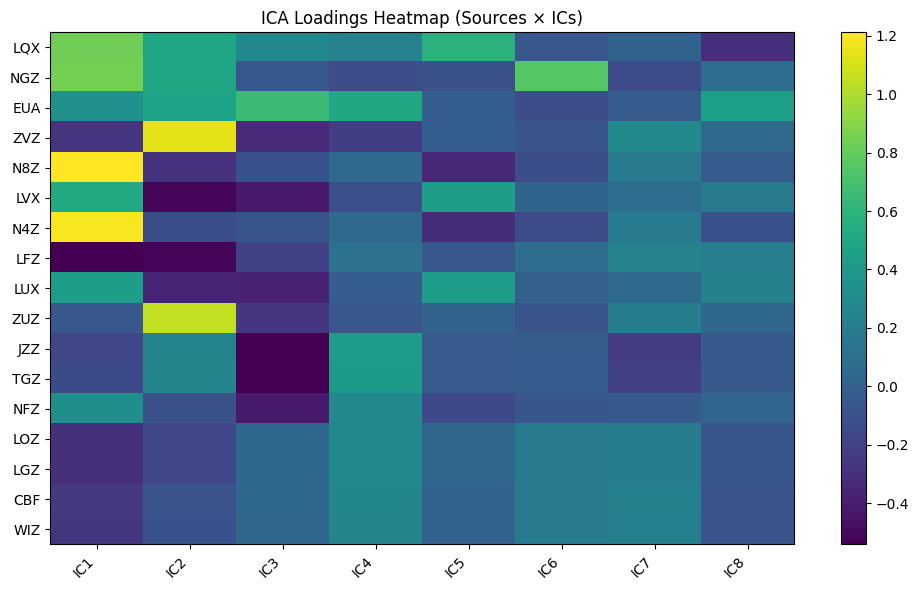

In [10]:
import matplotlib.pyplot as plt

row_order = A_df.abs().sum(axis=1).sort_values(ascending=False).index
A_plot = A_df.loc[row_order]

plt.figure(figsize=(10, 6))
im = plt.imshow(A_plot.values, aspect="auto")
plt.colorbar(im)
plt.yticks(range(len(A_plot.index)), A_plot.index)
plt.xticks(range(len(A_plot.columns)), A_plot.columns, rotation=45, ha="right")
plt.title("ICA Loadings Heatmap (Sources × ICs)")
plt.tight_layout()
plt.show()


2. ICA Loadings Heatmap (Column-normalized)

- What this plot shows
    - Each IC (column) is normalized by its own maximum absolute loading: $\color{cyan}{\tilde{A}_{i,j} = \frac{A_{i,j}}{\max_i \left| A_{i,j} \right|}}$
    - Values are rescaled to the range [-1, 1] for every IC.
    - Magnitude differences between ICs are removed.

- How to interpret
    - This heatmap emphasizes structure and relative roles within each IC.
    - Bright positive values (≈ +1): dominant positive contributors
    - Bright negative values (≈ −1): dominant negative contributors
    - It reveals:
        - Whether an IC is a market-wide (same-sign) factor
        - Or a spread / substitution factor with opposing signs

- Use case
    - Interpreting the economic meaning of each IC
    - Identifying:
        - Carbon (EUA) factors
        - Gas-driven or power-driven factors
        - Fuel-switching or regional spread factors
- This is the preferred visualization for explanation and naming of ICs

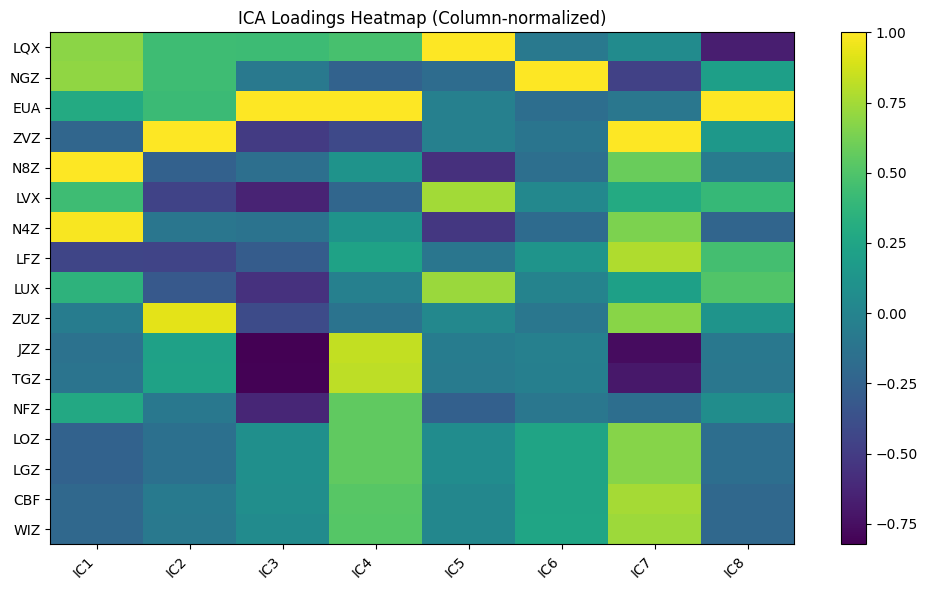

In [11]:
A_norm = A_df.copy()
A_norm = A_norm / (A_norm.abs().max(axis=0) + 1e-12)  # Scale each IC so that its maximum absolute loading equals 1
A_plot = A_norm.loc[row_order]

plt.figure(figsize=(10, 6))
im = plt.imshow(A_plot.values, aspect="auto")
plt.colorbar(im)
plt.yticks(range(len(A_plot.index)), A_plot.index)
plt.xticks(range(len(A_plot.columns)), A_plot.columns, rotation=45, ha="right")
plt.title("ICA Loadings Heatmap (Column-normalized)")
plt.tight_layout()
plt.show()


## Identifiability Considerations

It is important to note that ICA solutions are not unique in terms of
component order, sign, or scale.
As a result:

- The ordering of independent components has no intrinsic meaning.
- The sign of a component may be arbitrarily flipped.
- The magnitude of component loadings is only interpretable in a
  relative sense.

Accordingly, comparisons across ICA methods focus on structural
similarity and temporal alignment rather than absolute magnitude.


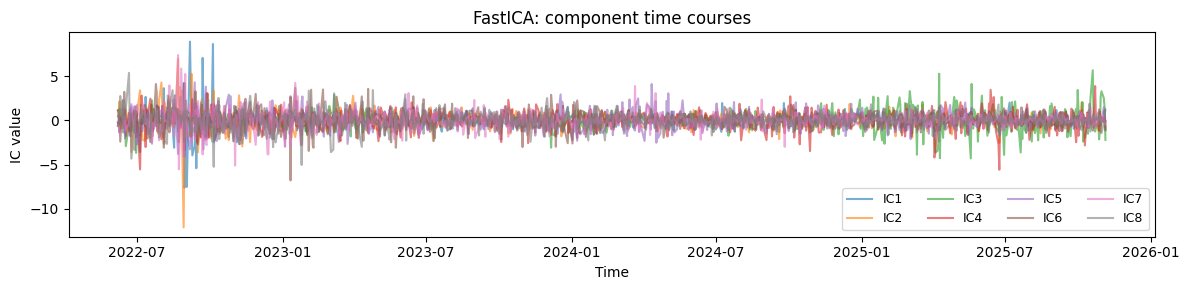

In [12]:
plt.figure(figsize=(12, 3))

for col in S_df.columns:
    plt.plot(S_df.index, S_df[col], label=col, alpha=0.6)

plt.title("FastICA: component time courses")
plt.xlabel("Time")
plt.ylabel("IC value")
plt.legend(ncol=4, fontsize=9)
plt.tight_layout()
plt.show()

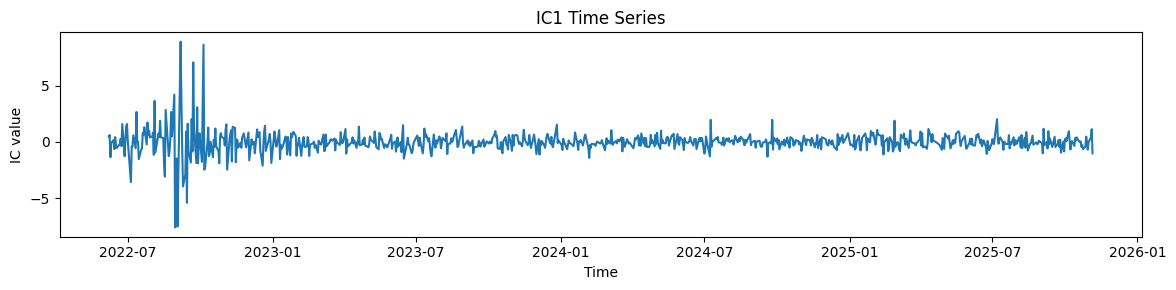

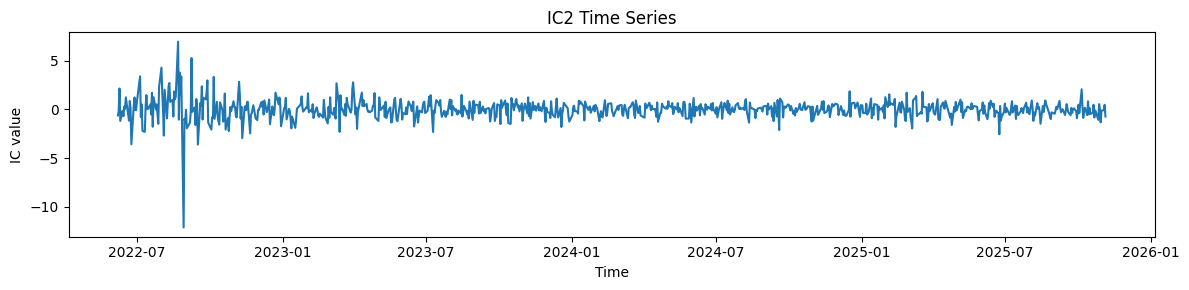

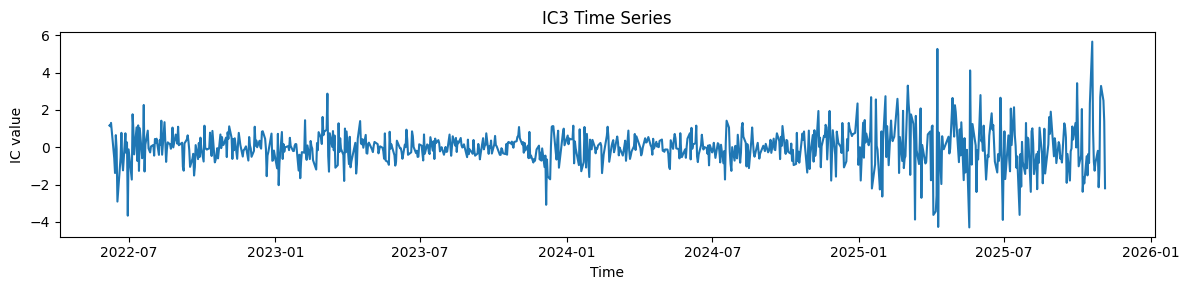

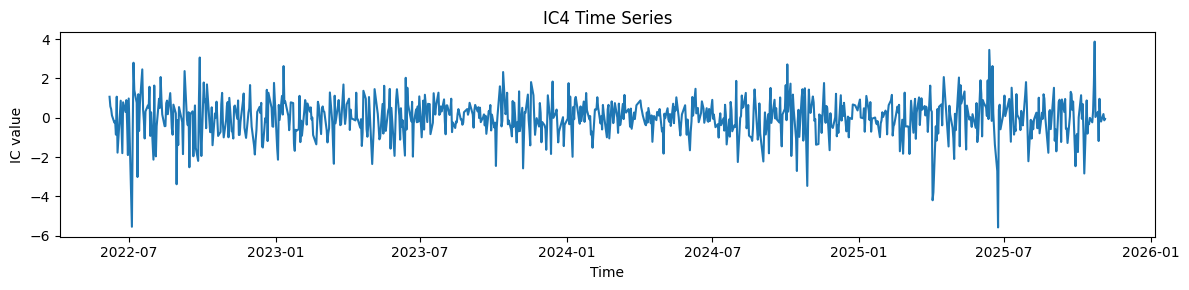

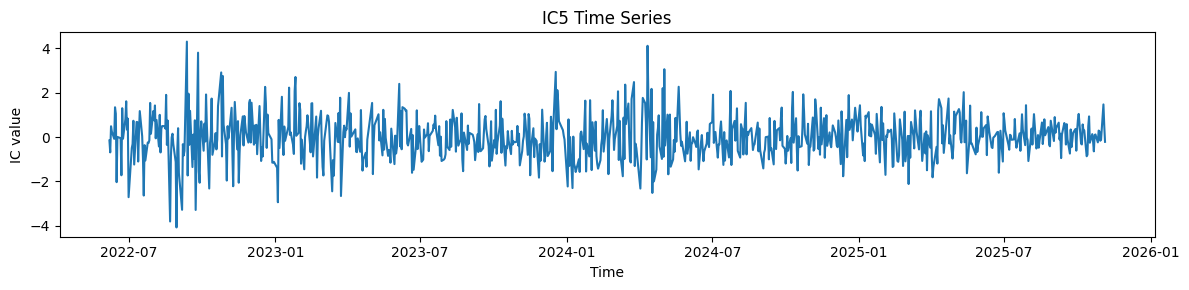

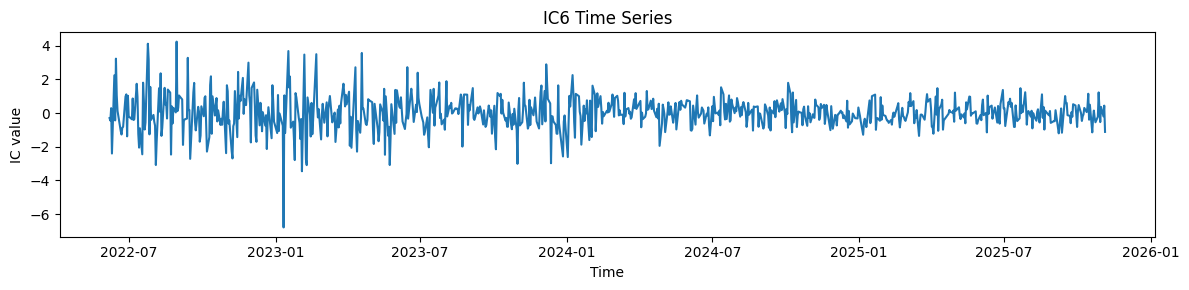

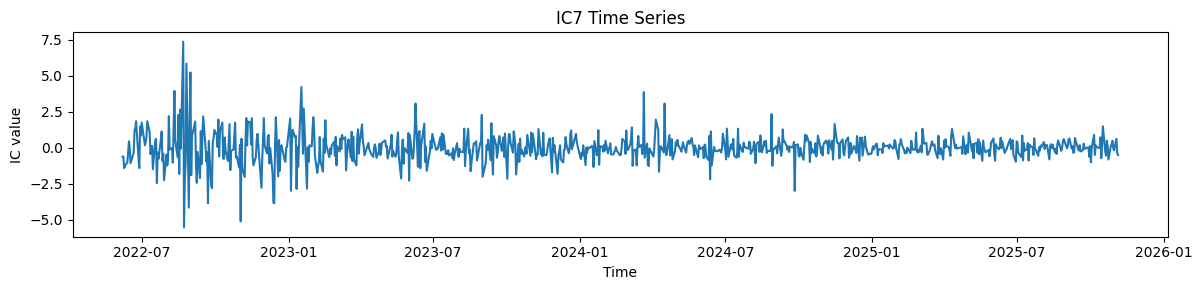

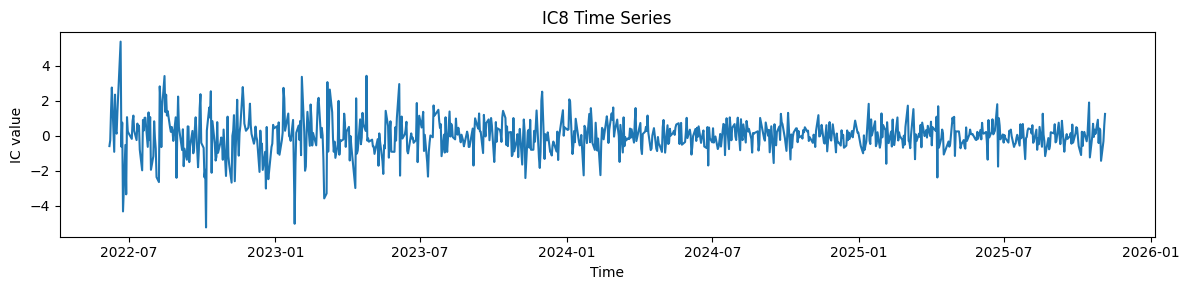

In [13]:
for col in S_df.columns:
    plt.figure(figsize=(12, 3))
    plt.plot(S_df.index, S_df[col])
    plt.title(f"{col} Time Series")
    plt.xlabel("Time")
    plt.ylabel("IC value")
    plt.tight_layout()
    plt.show()


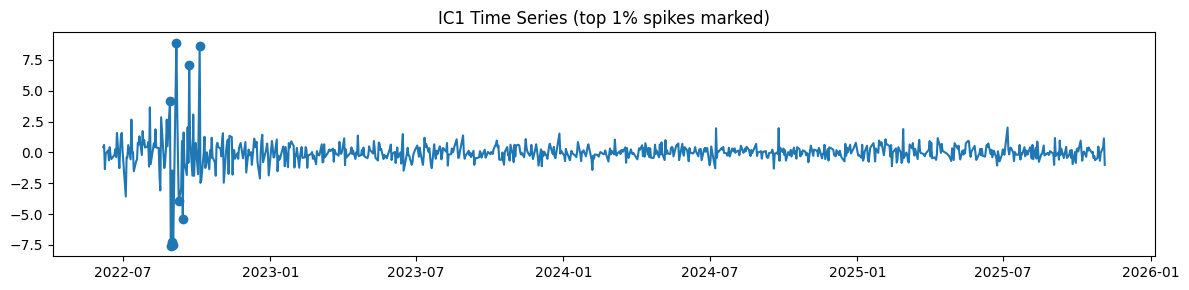

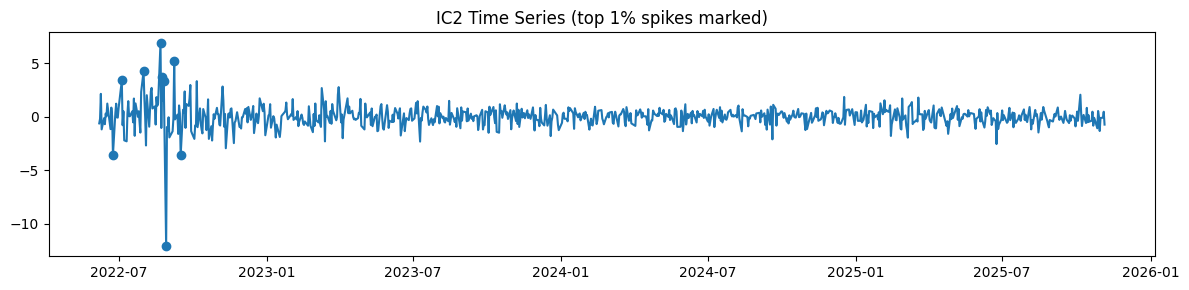

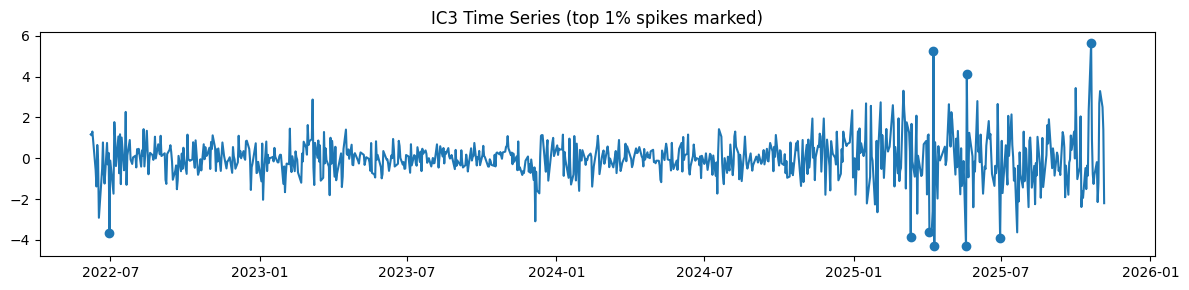

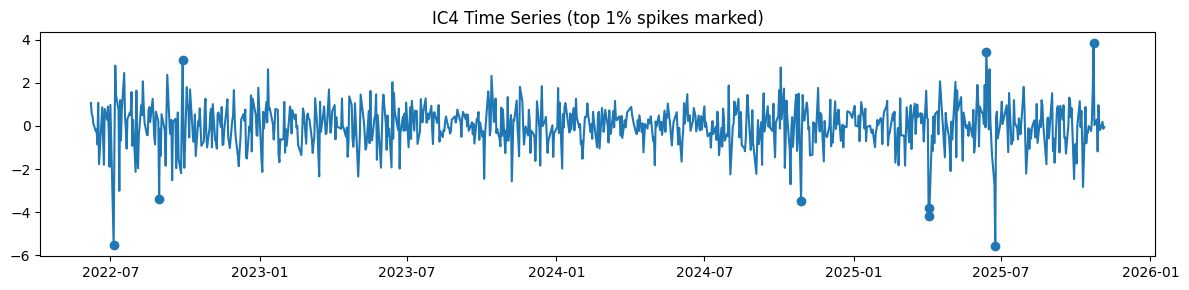

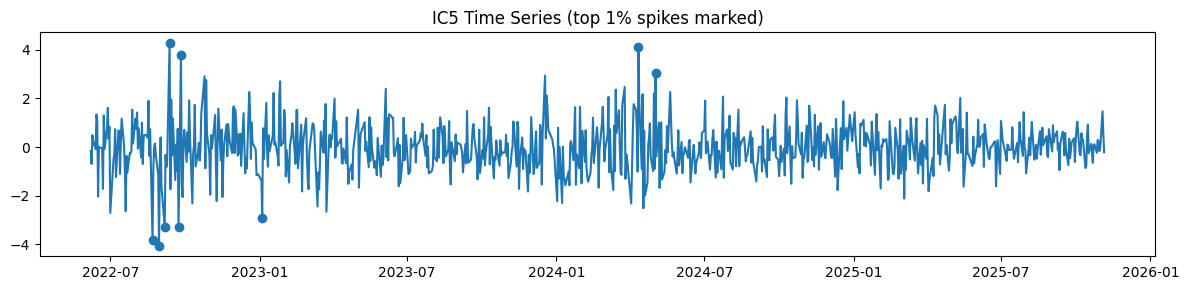

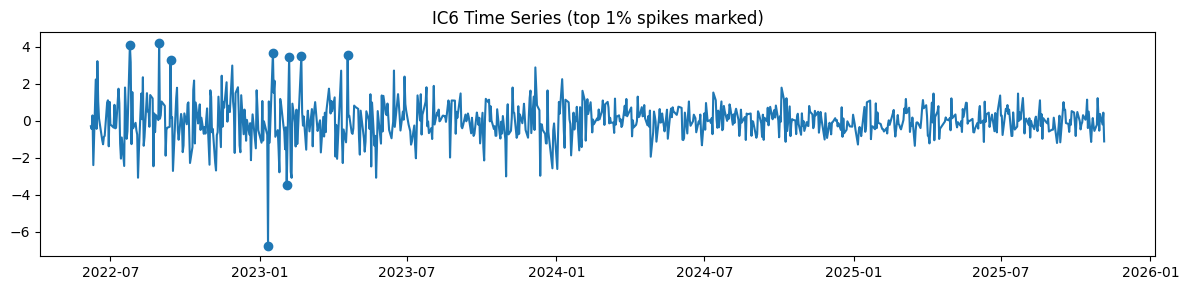

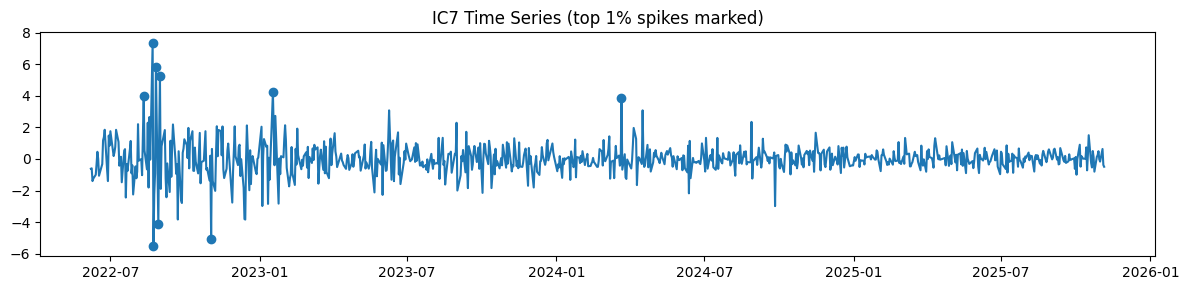

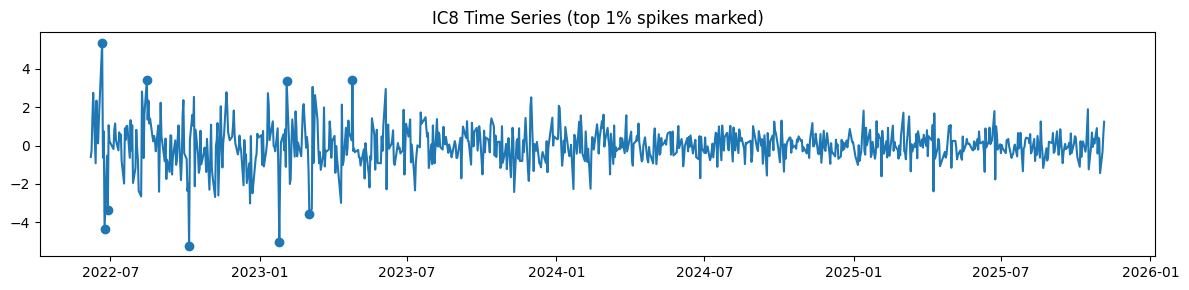

In [14]:
for col in S_df.columns:
    s = S_df[col]
    thr = s.abs().quantile(0.99)  # Identify the most extreme 1% of values as peaks
    peaks = s.index[s.abs() >= thr]

    plt.figure(figsize=(12, 3))
    plt.plot(s.index, s.values)
    plt.scatter(peaks, s.loc[peaks].values, marker="o")  
    plt.title(f"{col} Time Series (top 1% spikes marked)")
    plt.tight_layout()
    plt.show()


In [15]:
def l1_l2_ratio(A_df):
    out = {}
    for ic in A_df.columns:
        a = A_df[ic].values
        out[ic] = np.sum(np.abs(a)) / (np.linalg.norm(a) + 1e-12)
    return pd.Series(out)

s_fast = l1_l2_ratio(A_df)

print("FastICA sparsity:\n", s_fast)


FastICA sparsity:
 IC1    3.351787
IC2    3.262572
IC3    3.292724
IC4    3.482728
IC5    2.679132
IC6    2.639397
IC7    3.695543
IC8    3.119905
dtype: float64


## Sparse ICA Implementation

Sparse ICA results are obtained using an R-based implementation and
subsequently imported into Python for comparison and analysis.
Only the estimated components and mixing matrices are used in this
notebook.


In [16]:
# from R
s_sparse = pd.Series(
    {
        "IC1": 1.436171,
        "IC2": 1.487445,
        "IC3": 2.249793,
        "IC4": 2.721500,
        "IC5": 1.436137,
        "IC6": 1.507484,
        "IC7": 2.349216,
        "IC8": 1.500862,
    },
    name="SparseICA"
)

<Figure size 1000x400 with 0 Axes>

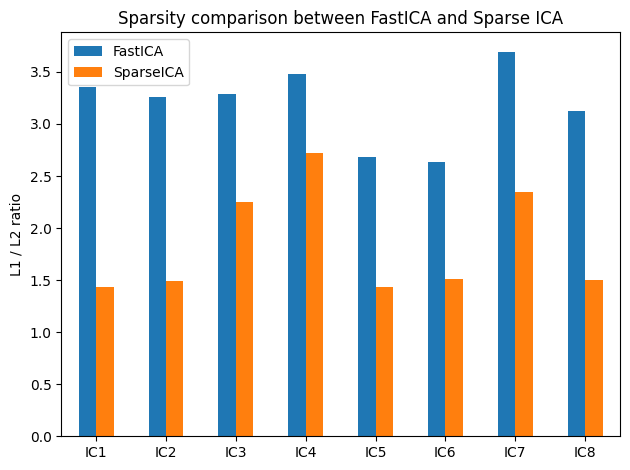

In [17]:
sparsity_df = pd.DataFrame({
    "FastICA": s_fast,
    "SparseICA": s_sparse
})

plt.figure(figsize=(10,4))
sparsity_df.plot(kind="bar")
plt.ylabel("L1 / L2 ratio")
plt.title("Sparsity comparison between FastICA and Sparse ICA")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 400x400 with 0 Axes>

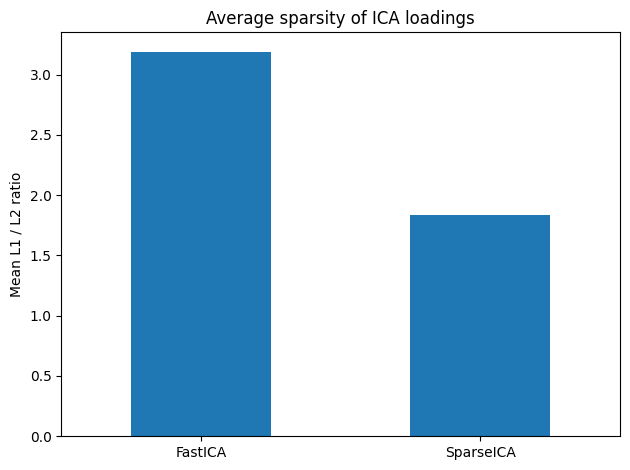

In [18]:
mean_df = sparsity_df.mean().to_frame("Mean L1/L2 ratio")

plt.figure(figsize=(4,4))
mean_df.plot(kind="bar", legend=False)
plt.ylabel("Mean L1 / L2 ratio")
plt.title("Average sparsity of ICA loadings")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [19]:
# Sparse ICA (from R)
M_sparse = pd.read_csv("./data/sparseICA_M.csv", index_col=0)

# Transpose to T x K to align with the FastICA time courses (S_df)
S_sparse_df = M_sparse.T

# FastICA time courses (S_df) already exist
S_fast_df = S_df.loc[S_df.index]

print(S_sparse_df)
print(S_fast_df)

                 IC1       IC2       IC3       IC4       IC5       IC6  \
2022-06-07 -0.006216 -0.008721 -0.005439 -0.008585 -0.001054  0.002221   
2022-06-08 -0.005232 -0.001540 -0.006766 -0.001789 -0.004528  0.003861   
2022-06-09  0.001752 -0.001474  0.009415  0.012191  0.000186  0.002537   
2022-06-10 -0.008934 -0.013184  0.009826 -0.004684  0.003687  0.005053   
2022-06-13  0.001327  0.009770  0.001587 -0.004609 -0.000940 -0.002486   
...              ...       ...       ...       ...       ...       ...   
2025-10-30 -0.006096 -0.000261  0.000028 -0.011922  0.001627  0.011536   
2025-10-31 -0.002272  0.001546 -0.008708 -0.003615  0.000369  0.011967   
2025-11-03  0.006806 -0.002136 -0.003940  0.004177  0.005981  0.006045   
2025-11-04 -0.002084 -0.000255  0.004287  0.009968  0.000534  0.001249   
2025-11-05 -0.002096  0.001506  0.002221 -0.007252  0.000661 -0.002807   

                 IC7       IC8  
2022-06-07  0.000260 -0.005295  
2022-06-08  0.002557 -0.004915  
2022-06-09 -

In [20]:
S_fast_df.index = pd.to_datetime(S_fast_df.index)
S_sparse_df.index = pd.to_datetime(S_sparse_df.index)

S_fast_df = S_fast_df.sort_index()
S_sparse_df = S_sparse_df.sort_index()

S_fast, S_sparse = S_fast_df.align(S_sparse_df, join="inner", axis=0)

corr_mat = pd.DataFrame(
    np.abs(np.corrcoef(S_fast.values.T, S_sparse.values.T)[:8, 8:]),
    index=S_fast.columns,
    columns=S_sparse.columns
)

print(corr_mat)


          IC1       IC2       IC3       IC4       IC5       IC6       IC7  \
IC1  0.037589  0.251395  0.058724  0.345553  0.160714  0.281155  0.953585   
IC2  0.340172  0.173111  0.015507  0.846882  0.224405  0.260963  0.047757   
IC3  0.007807  0.056282  0.006865  0.013533  0.003433  0.728903  0.033132   
IC4  0.192011  0.380480  0.291486  0.182590  0.380517  0.370081  0.240188   
IC5  0.180985  0.098707  0.031762  0.257731  0.866901  0.283424  0.105083   
IC6  0.073762  0.803060  0.449663  0.059706  0.127663  0.253334  0.096486   
IC7  0.752115  0.054060  0.120337  0.088751  0.012596  0.097147  0.014285   
IC8  0.032585  0.010956  0.824312  0.218205  0.080330  0.143304  0.061983   

          IC8  
IC1  0.081013  
IC2  0.227940  
IC3  0.063234  
IC4  0.171637  
IC5  0.075362  
IC6  0.045501  
IC7  0.874111  
IC8  0.009215  


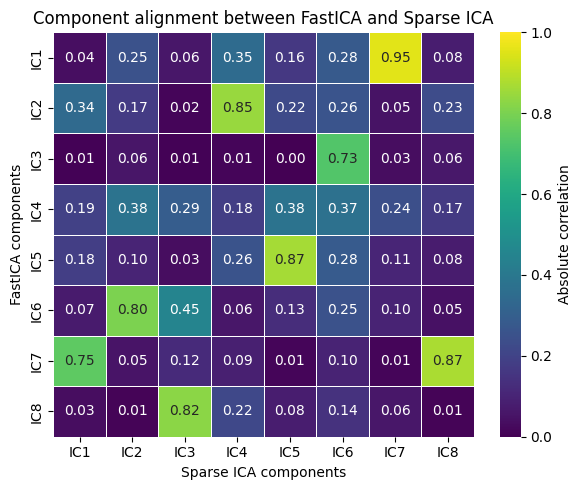

In [21]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_mat,
    cmap="viridis",
    annot=True,
    fmt=".2f",
    vmin=0, vmax=1,
    linewidths=0.5,
    cbar_kws={"label": "Absolute correlation"}
)

plt.xlabel("Sparse ICA components")
plt.ylabel("FastICA components")
plt.title("Component alignment between FastICA and Sparse ICA")
plt.tight_layout()
plt.show()

## Comparison Between FastICA and Sparse ICA

While the two ICA variants produce components with similar temporal
structures, differences in amplitude and sparsity are observed.

Sparse ICA generally yields components with lower effective support,
suggesting that sparsity constraints help isolate more localized
relationships among energy markets.

Given the inherent non-identifiability of ICA, these differences are
interpreted as variations in representation rather than contradictions
in underlying structure.


## Summary

This notebook demonstrates that ICA can extract meaningful latent
structures from multivariate energy futures returns.

The identified components provide a basis for economic interpretation
and further analysis, such as linking components to real-world events
or comparing factor stability across time.
